Create a **classifier** using eithera a Deep Network with pyTorch

The classifier can take as input some user generated data, e.g. a partition of the [0,1]x[0,1] square (x1 > x2^2).

Complete the code below where indicated

Use pytorch docs as needed


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import torch
import torch.nn as nn


Generate some data

In [ ]:
from math import *
# Fixing random state for reproducibility
np.random.seed(123)

#try changing this
theFunction = lambda x1,x2 : np.sin(x1*20) > x2*x2 - x1  #FILL HERE# Try using a different function, keep in mind x1 and x2 are numpy arrays!

N=3000
x1 = 1.0 * np.random.rand(N)
x2 = 1.0 * np.random.rand(N)
ynp=theFunction(x1,x2)


print(x1[:10])
print(x2[:10])
Xnp=np.stack((x1,x2),axis=1) #FILL HERE# create a matrix with two columns one with data from x1, the other from x2


print(x1)
print(x2)
print(Xnp)
print(ynp)


[0.69646919 0.28613933 0.22685145 0.55131477 0.71946897 0.42310646
 0.9807642  0.68482974 0.4809319  0.39211752]
[0.96942611 0.72178369 0.18189166 0.88202837 0.47702151 0.84685675
 0.83090753 0.01735057 0.23366189 0.91109161]
[0.69646919 0.28613933 0.22685145 ... 0.20891734 0.56747224 0.4452157 ]
[0.96942611 0.72178369 0.18189166 ... 0.48573207 0.67061293 0.13578975]
[[0.69646919 0.96942611]
 [0.28613933 0.72178369]
 [0.22685145 0.18189166]
 ...
 [0.20891734 0.48573207]
 [0.56747224 0.67061293]
 [0.4452157  0.13578975]]
[ True False False ... False False  True]


Now let's look  at the data we generated, does it look like you expect?


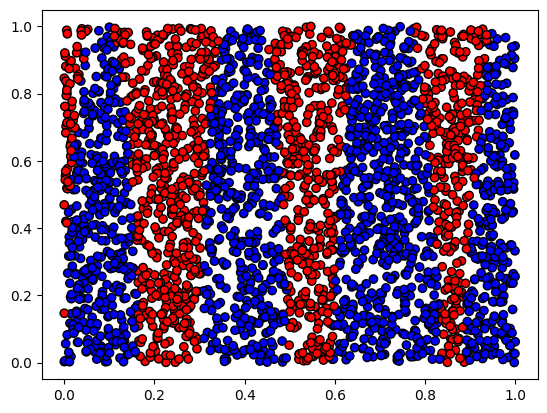

In [ ]:
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
plt.scatter(Xnp[:, 0], Xnp[:, 1], c=ynp, cmap=cm_bright, edgecolors='k')


Let's compare with a colormap made using directly the generating function (remember, in real case world we will not know such function)

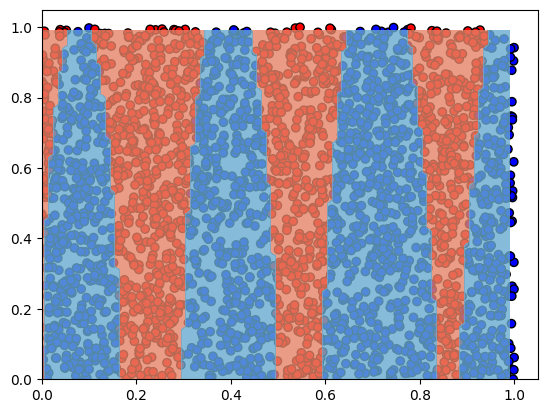

In [ ]:
xx1, xx2 = np.meshgrid(np.arange(0, 1, 0.01),np.arange(0, 1, 0.01))
plt.scatter(Xnp[:, 0], Xnp[:, 1], c=ynp, cmap=cm_bright, edgecolors='k')
plt.contourf(xx1, xx2, (theFunction(xx1,xx2)).reshape(xx1.shape), cmap=plt.cm.RdBu, alpha=.8)

In pytorch the numpy data must be loaded on "tensors"

In [ ]:

X = torch.tensor(Xnp, dtype=torch.float32).to("cuda") #for GPU
y = torch.tensor(ynp, dtype=torch.float32).reshape(-1, 1).to("cuda")
print(X)
print(y)

tensor([[0.6965, 0.9694],
        [0.2861, 0.7218],
        [0.2269, 0.1819],
        ...,
        [0.2089, 0.4857],
        [0.5675, 0.6706],
        [0.4452, 0.1358]], device='cuda:0')
tensor([[1.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [1.]], device='cuda:0')


In [ ]:
class MySimpleDNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(2, 50)
        self.layer2 = nn.Linear(50, 50)
        self.layer3 = nn.Linear(50, 50)
        self.output = nn.Linear(50, 1)
    def forward(self,x):
        h = self.layer1(x)
        h = h.relu()
        h = self.layer2(h)
        h = h.relu()
        h = self.layer3(h)
        h = h.relu()
        h = self.output(h)
        h = torch.sigmoid(h)
        return h


model = MySimpleDNN().to("cuda")
print(model)
print([x for x in model.parameters()])

MySimpleDNN(
  (layer1): Linear(in_features=2, out_features=50, bias=True)
  (layer2): Linear(in_features=50, out_features=50, bias=True)
  (layer3): Linear(in_features=50, out_features=50, bias=True)
  (output): Linear(in_features=50, out_features=1, bias=True)
)
[Parameter containing:
tensor([[-0.4462,  0.4362],
        [ 0.1549,  0.1715],
        [-0.6087,  0.0368],
        [-0.5363, -0.4184],
        [-0.0256,  0.0870],
        [ 0.3584,  0.5333],
        [ 0.5486, -0.1956],
        [-0.4231,  0.0622],
        [-0.1411,  0.3117],
        [ 0.0575,  0.3021],
        [ 0.5502,  0.4322],
        [ 0.6889,  0.3285],
        [-0.0524, -0.2867],
        [-0.6466,  0.2116],
        [-0.2632, -0.3292],
        [ 0.2115, -0.2207],
        [-0.3952,  0.2850],
        [ 0.1934, -0.1479],
        [-0.1754,  0.2600],
        [ 0.3788, -0.6861],
        [ 0.1773, -0.2086],
        [ 0.1562,  0.2828],
        [-0.5648, -0.6508],
        [ 0.4666, -0.3816],
        [ 0.0820,  0.6620],
        [-0.

In pytorch the training is done explictely


In [ ]:
import torch.optim as optim
import time
loss_fn = nn.BCELoss()  # binary cross entropy
optimizer = optim.Adam(model.parameters(), lr=0.002)

n_epochs = 500
batch_size = 128
loss_history=[]
for epoch in range(n_epochs):
    starttime=time.time()
    for i in range(0, len(X), batch_size):
        Xbatch = X[i:i+batch_size]
        y_pred = model(Xbatch)
        ybatch = y[i:i+batch_size]
        loss = loss_fn(y_pred, ybatch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f'Finished epoch {epoch}, latest loss {loss} in', time.time()-starttime, "seconds")
    loss_history.append(loss.cpu().detach().numpy())



Finished epoch 0, latest loss 0.6706355214118958 in 0.6871213912963867 seconds
Finished epoch 1, latest loss 0.6145944595336914 in 0.03705739974975586 seconds
Finished epoch 2, latest loss 0.619728684425354 in 0.03634834289550781 seconds
Finished epoch 3, latest loss 0.6131765246391296 in 0.035604238510131836 seconds
Finished epoch 4, latest loss 0.6110087633132935 in 0.03735756874084473 seconds
Finished epoch 5, latest loss 0.6094028949737549 in 0.037851572036743164 seconds
Finished epoch 6, latest loss 0.6062018871307373 in 0.03863883018493652 seconds
Finished epoch 7, latest loss 0.6010843515396118 in 0.036165475845336914 seconds
Finished epoch 8, latest loss 0.5949556231498718 in 0.03544259071350098 seconds
Finished epoch 9, latest loss 0.5884854793548584 in 0.037589073181152344 seconds
Finished epoch 10, latest loss 0.582722544670105 in 0.035437583923339844 seconds
Finished epoch 11, latest loss 0.5792695879936218 in 0.03563809394836426 seconds
Finished epoch 12, latest loss 0.575

In the history object a history.history dictionary contains the validation and training loss vs epoch, let's try to plot them and compare to evaluate the training

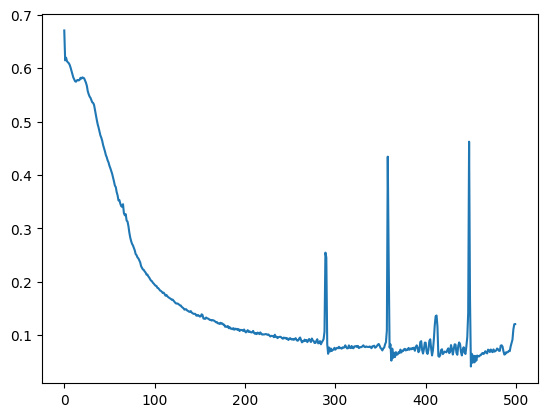

In [ ]:
plt.plot(loss_history)
plt.show()





Now let's try to evaluate our model on the xx1,xx2 points we created earlier)

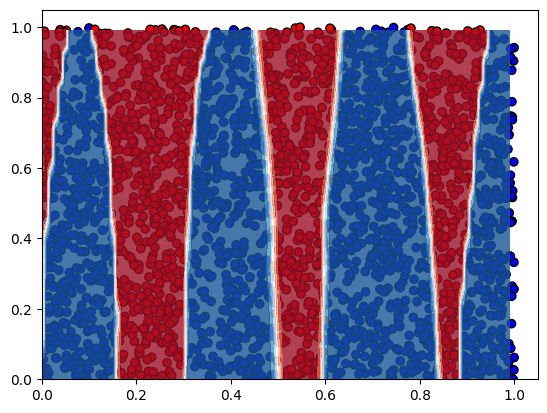

In [ ]:
testSet=np.stack((xx1.flatten(), xx2.flatten()), axis=-1)

torch.no_grad()
pred = model(torch.tensor(testSet, dtype=torch.float32).to("cuda"))
pred = pred.cpu().detach().numpy()

plt.scatter(Xnp[:, 0], Xnp[:, 1], c=ynp, cmap=cm_bright, edgecolors='k')
plt.contourf(xx1, xx2, pred.reshape(xx1.shape), cmap=plt.cm.RdBu, alpha=.8)